In [1]:
library(ggplot2)
library(Hmisc)
source("../utilis/utilis.R")
library(glue)
library(dplyr)


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
threshold = 1
cutoff_column = 'pval'
data_df_path =  '../../../output/hMinImp_TICnorm_groupFil0.3_RPneg_1wayANOVA/PS_sel_one_wayANOVA_hMinImp_TICnorm_groupFil0.3_RPneg_fullreport.csv'
meta_df_path =  '../../../../seq/RPneg_addgrp.csv'

# Prepare the data

## Read and transform the data table and metadata table

In [6]:
PS_df = read.csv(data_df_path)
meta_df = read.csv(meta_df_path)

----

In [7]:
grepl('(Tn|CD8stem|CD8TD|CD8trans)\\_[0-9]+',colnames(PS_df))

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
[37]  TRUE  TRUE  TRUE FALSE FALSE FALSE

In [8]:
data_df = PS_df[grepl('(Tn|CD8stem|CD8TD|CD8trans)\\_[0-9]+',colnames(PS_df))]

In [9]:
head(data_df)

,CD8TD_750K_1,CD8TD_750K_2,CD8stem_250K_1,CD8stem_300K_2,CD8trans_250K_2,CD8trans_350K_1,Tn_250K_1,Tn_250K_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,21.76329,21.86124,22.15218,22.33243,22.05573,22.41003,22.47504,22.62447
2,17.08924,17.73458,19.49869,19.46319,18.76382,17.99717,19.02478,19.10794
3,20.50078,20.92549,21.16842,21.39104,21.14028,21.21081,21.64365,21.76940
4,18.88689,20.67266,19.81125,20.19701,18.88689,20.48852,18.88689,18.88689
5,22.80002,19.40956,23.19147,19.40956,22.33489,23.47578,22.15057,21.94778
6,21.62814,21.08936,19.57186,20.75036,20.77075,20.82799,20.83698,21.04747


----

In [10]:
head(meta_df)

,Sample.Type,File.Name,Sample.ID,Sample_ID_upd,cell_number,group,Comment,Path,Instrument.Method,Process.Method,Position,Inj.Vol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>,<chr>,<int>
1,Blank,Blank_20230308_002,Blank_20230308_002,Blank_1,NR,Blank,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A1,2
2,Blank,Blank_20230308_004,Blank_20230308_004,Blank_2,NR,Blank,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A1,2
3,Blank,Blank_std_20230308_1_002,Blank_std_20230308_002,Blank_std_1,NR,Blank_std,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A2,2
4,QC,MT_20230308_002,Qstd_20230308_002,Qstd_1,NR,Qstd,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A3,2
5,QC,MT_20230308_004,Qstd_20230308_004,Qstd_2,NR,Qstd,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A3,2
6,Unknown,MT_20230308_006,pooledsample_02,pooled_1,NA,pooled,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A4,5


In [23]:
rownames(meta_df) = meta_df$Sample_ID_upd

----

In [22]:
# lookUpAnnot <- function(annot_df,
#                         FeatureID,
#                         look4column = '') {
#     output = annot_df[annot_df[,'id_number'] == FeatureID,look4column]
#     return(output)
# }

# lookUpAnnot(annot_df,'F8342','Species.Shorthand')

## Transform and merge data

In [24]:
source('../utilis/utilis.R')
transform_merge_data4violin <- function(df = df,
                                 meta_df = meta_df,
                                 class_column = 'group',
                                 cutoff_column = 'padj', 
                                 threshold = threshold) {
    
    df_filt <- df[df[,cutoff_column] < threshold,
              colnames(df)[grepl('(Tn|CD8stem|CD8TD|CD8trans)\\_[0-9]+',colnames(df))]] # 
    df_filt.T <- t(df_filt)
    # print(head(df_filt.T))
    merged_df = merge_by_rowName(meta_df,df_filt.T, all.y = TRUE)
    merged_df[,class_column] = factor(
        merged_df[,class_column],
        level = c('Tn',
                  'CD8stem',
                  'CD8trans',
                  'CD8TD')
    )
    return(merged_df)
}

In [25]:
merged_df <- transform_merge_data4violin(df = PS_df,
                                         meta_df = meta_df,
                                         class_column = 'group',
                                         cutoff_column = 'pval', 
                                         threshold = threshold)

In [26]:
colnames(merged_df)

[1] "Sample.Type"       "File.Name"         "Sample.ID"        
 [4] "Sample_ID_upd"     "cell_number"       "group"            
 [7] "Comment"           "Path"              "Instrument.Method"
[10] "Process.Method"    "Position"          "Inj.Vol"          
[13] "1"                 "2"                 "3"                
[16] "4"                 "5"                 "6"                
[19] "7"                 "8"                 "9"                
[22] "10"                "11"                "12"               
[25] "13"                "14"                "15"               
[28] "16"                "17"                "18"               
[31] "19"                "20"                "21"               
[34] "22"                "23"                "24"               
[37] "25"                "26"                "27"               
[40] "28"                "29"                "30"               
[43] "31"                "32"                "33"               
[46] "34"                "35"                "36"               
[49] "37"                "38"                "39"               
[52] "40"                "41"

# Output directory

In [17]:
output_dir = "../../../output/hMinImp_TICnorm_groupFil0.3_RPneg_1wayANOVA/PS_including_LPS_sum_boxplot/"
dir.create(output_dir)

In [18]:
ncol(meta_df)

[1] 12

In [31]:
merged_df[1:5,ncol(meta_df):ncol(merged_df)]

,Inj.Vol,1,2,3,4,5,6,7,8,9,⋯,32,33,34,35,36,37,38,39,40,41
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD8stem_250K_1,5,22.15218,19.49869,21.16842,19.81125,23.19147,19.57186,16.20551,20.96995,20.92007,⋯,21.21818,20.14743,20.93692,22.27754,21.63438,21.24867,20.60021,20.48131,12.41164,20.72228
CD8stem_300K_2,5,22.33243,19.46319,21.39104,20.19701,19.40956,20.75036,16.20551,21.13401,20.99212,⋯,21.16143,20.14743,19.96708,22.46434,20.72743,21.31945,19.72615,20.95596,12.41164,20.54497
CD8TD_750K_1,5,21.76329,17.08924,20.50078,18.88689,22.80002,21.62814,17.85737,21.52266,20.43571,⋯,22.27786,21.79929,17.90540,22.50889,18.59876,19.54137,19.72615,20.16354,12.41164,19.24703
CD8TD_750K_2,5,21.86124,17.73458,20.92549,20.67266,19.40956,21.08936,18.07915,21.45655,16.43686,⋯,21.89531,21.89787,17.90540,22.56430,21.06326,20.67891,19.72615,20.11891,13.92914,19.24703
CD8trans_250K_2,5,22.05573,18.76382,21.14028,18.88689,22.33489,20.77075,16.20551,21.16761,21.46730,⋯,21.44646,20.14743,20.14513,22.24143,20.94642,21.63505,20.66969,21.39837,13.57494,20.98709


In [33]:
rowsums = rowSums(merged_df[,(ncol(meta_df)+1):ncol(merged_df)])

In [38]:
merged_df[,3:5]

,Sample.ID,Sample_ID_upd,cell_number
,<chr>,<chr>,<chr>
CD8stem_250K_1,CD8T_stem_250k_01_02,CD8stem_250K_1,250000
CD8stem_300K_2,CD8T_stem_300k_01_02,CD8stem_300K_2,300000
CD8TD_750K_1,CD8T_TD_750k_01_02,CD8TD_750K_1,750000
CD8TD_750K_2,CD8T_TD_750k_01_02,CD8TD_750K_2,750000
CD8trans_250K_2,CD8T_trans_250k_01_02,CD8trans_250K_2,250000
CD8trans_350K_1,CD8T_trans_350k_01_02,CD8trans_350K_1,350000
Tn_250K_1,Naive_250k_01_02,Tn_250K_1,250000
Tn_250K_2,Naive_250k_02_02,Tn_250K_2,250000


In [41]:
PSsum_df = merged_df[,3:7] # 
PSsum_df$PS_sum = rowsums

In [42]:
PSsum_df

,Sample.ID,Sample_ID_upd,cell_number,group,Comment,PS_sum
,<chr>,<chr>,<chr>,<fct>,<int>,<dbl>
CD8stem_250K_1,CD8T_stem_250k_01_02,CD8stem_250K_1,250000,CD8stem,1,836.4259
CD8stem_300K_2,CD8T_stem_300k_01_02,CD8stem_300K_2,300000,CD8stem,1,827.8921
CD8TD_750K_1,CD8T_TD_750k_01_02,CD8TD_750K_1,750000,CD8TD,1,848.0755
CD8TD_750K_2,CD8T_TD_750k_01_02,CD8TD_750K_2,750000,CD8TD,1,844.4034
CD8trans_250K_2,CD8T_trans_250k_01_02,CD8trans_250K_2,250000,CD8trans,1,842.4941
CD8trans_350K_1,CD8T_trans_350k_01_02,CD8trans_350K_1,350000,CD8trans,1,837.2981
Tn_250K_1,Naive_250k_01_02,Tn_250K_1,250000,Tn,1,837.6214
Tn_250K_2,Naive_250k_02_02,Tn_250K_2,250000,Tn,1,841.8554


# Wrapper Function: plot a single box plot

In [45]:
box_plot <- function(long_df = merged_df,
                        x = 'group',
                        y = var,
                        xlab = xlab,
                        ylab = ylab,
                        fill_color = 'group',
                        fig_width = 8,
                        fig_height = 8,
                        text_size = 20,
                        legend_size = 20,
                        axis_title_size = 20,
                        output_dir = "",
                        pdf_prefix = 'test',
                        show_plot = TRUE) {
    
    options(repr.plot.width = fig_width, repr.plot.height = fig_height)

    p <- ggplot(long_df, aes_string(x = x, y = y, fill = fill_color)) + 
        geom_boxplot(outlier.shape = NA) +
        xlab(xlab) + ylab(ylab) + 
        geom_jitter(alpha = 1) +
        scale_fill_manual(values = c("#888888","#0000ff","#FFA500","#ff0000")) +  #

        # set transparency
        # https://ggplot2.tidyverse.org/reference/theme.html
        theme(
          panel.grid.major = element_line(colour = "grey50",linetype = "dashed", size = 0.2),
          panel.border = element_rect(fill = NA),
          #panel.grid.minor = element_blank(),
          panel.background = element_rect(fill = "transparent",colour = NA),
          plot.background = element_rect(fill = "transparent",colour = NA),
          axis.text = element_text(size = text_size, colour="black"),
          axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5, colour="black"),
          legend.text= element_text(size = legend_size),
          legend.title = element_text(size = legend_size),
          axis.title = element_text(size = axis_title_size)
        )
    if (show_plot == TRUE) {
        print(p) # display the plot
    } else {return(p)}

    if (length(output_dir)!=0) {
            ggsave(file.path(output_dir, paste0("ggplot_boxplot_",pdf_prefix,".pdf")), width = fig_width, height = fig_height)
        }
}

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


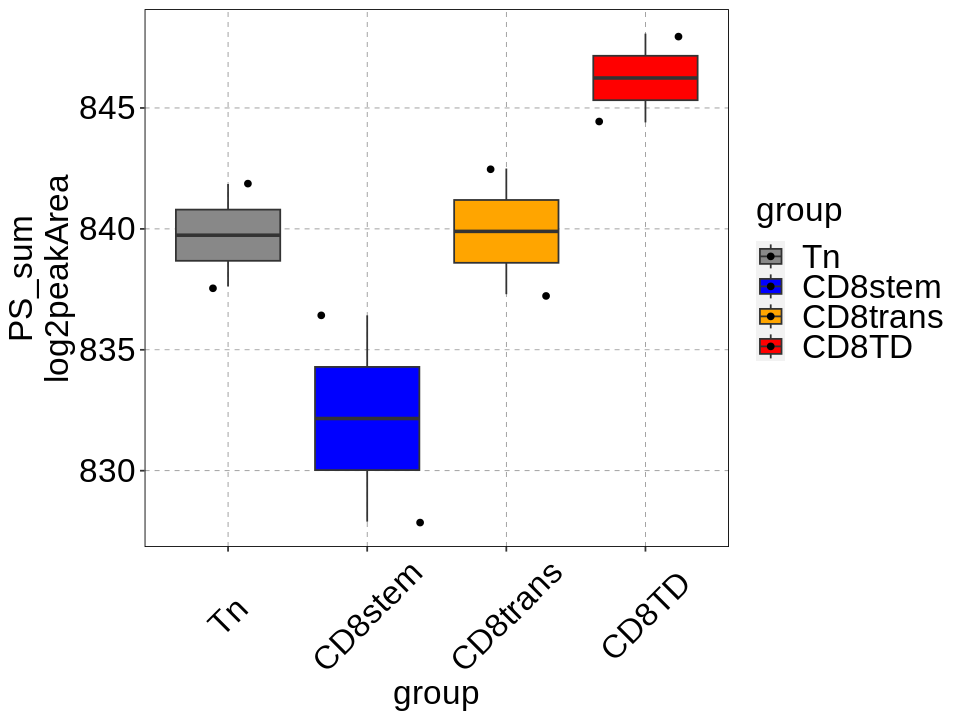

In [46]:
var = 'PS_sum'
box_plot(long_df = PSsum_df,
            x = 'group',
            y = var,
            xlab = 'group',
            ylab = glue('{var}\nlog2peakArea'),
            fill_color = 'group',
            fig_width = 8,
            fig_height = 6,
            text_size = 20,
            legend_size = 20,
            axis_title_size = 20,
            output_dir = output_dir,
            pdf_prefix = 'PS_sum_RPneg')